## Import libraries

In [1]:
first_folder_path = '../../../'

In [2]:
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from geopandas.tools import overlay
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, mean_squared_error
#import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import Dense
#from tensorflow.keras.utils import to_categorical

import os
import sys
module_path = os.path.abspath(os.path.join(first_folder_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Notebook config

In [3]:
# ----- ----- ----- Projection to be used when needed ----- ----- -----
projected_crs = "EPSG:32613"

## Load data

### __Load data__ - Guadalajara hexagon grid

In [4]:
hexs_type = "urban"
city = "Guadalajara"
query_urban = f"SELECT * FROM hexgrid.hexgrid_8_city_2020 WHERE \"city\" LIKE \'{city}\' AND \"type\" LIKE \'{hexs_type}\'"
query_urban

'SELECT * FROM hexgrid.hexgrid_8_city_2020 WHERE "city" LIKE \'Guadalajara\' AND "type" LIKE \'urban\''

In [5]:
hex_gdf = aup.gdf_from_query(query_urban, geometry_col='geometry')
# Show
print(hex_gdf.shape)
hex_gdf.head(2)

(1132, 6)


,hex_id_8,geometry,CVEGEO,NOMGEO,city,type
0,88498c9421fffff,"POLYGON ((-103.28663 20.69309, -103.28209 20.6...",14039,Guadalajara,Guadalajara,urban
1,88498c9405fffff,"POLYGON ((-103.30025 20.68392, -103.29571 20.6...",14039,Guadalajara,Guadalajara,urban


### __Load data__ - Nodes and edges

In [8]:
#Previous
#G, nodes, edges = aup.graph_from_hippo(hex_gdf, schema='osmnx', edges_folder='edges_elevation_23_line', nodes_folder='nodes_osmnx_23_point')

In [9]:
#Previous
#nodes = nodes.reset_index()
#nodes.head(2)

In [10]:
#Previous
#edges = edges.reset_index()
#edges.head(2)

In [11]:
#Previous
#edges_var = edges.copy()
#edges_var = edges_var.reset_index()
#edges_var = edges_var.to_crs("EPSG:32613")
#edges_var = edges_var[['u','v','key','osmid','grade_abs','geometry']] # Ya contiene a las prendientes.

In [13]:
# Read file
nodes = gpd.read_file(first_folder_path + "data/processed/volvo/project_network_initial_guadalajara/guadalajara_nodes_proj_net_rebuilt.gpkg")
# Filter for data of interest
nodes = nodes[['osmid','x','y','street_count','geometry']]
# Review CRS
if nodes.crs != projected_crs:
    nodes = nodes.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")

# Show
print(nodes.shape)
nodes.head(2)

(124621, 5)


,osmid,x,y,street_count,geometry
0,67637870229114485,676378.709485,2.291145e+06,3,POINT (676378.709 2291144.858)
1,67640019229114922,676400.196372,2.291149e+06,3,POINT (676400.196 2291149.223)


In [14]:
# Read file
edges = gpd.read_file(first_folder_path + "data/processed/volvo/project_network_initial_guadalajara/guadalajara_edges_proj_net_rebuilt.gpkg")
# Filter for data of interest
edges = edges[['u','v','key','geometry']]
# Review CRS
if edges.crs != projected_crs:
    edges = edges.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")

# Show
print(edges.shape)
edges.head(2)

(197439, 4)


,u,v,key,geometry
0,67637870229114485,67640019229114922,0,"MULTILINESTRING ((676378.709 2291144.858, 6763..."
1,67640019229114922,67640526229117504,0,"MULTILINESTRING ((676400.196 2291149.223, 6764..."


## Add __NDVI__ to analysis

In [15]:
ndvi_schema = "raster_analysis"
ndvi_table = "ndvi_analysis_hex"

query = f"SELECT * FROM {ndvi_schema}.{ndvi_table} WHERE city IN ('Guadalajara') AND res = 11";
ndvi_gdl = aup.gdf_from_query(query, geometry_col='geometry')
# Review CRS
if ndvi_gdl.crs != projected_crs:
    ndvi_gdl = ndvi_gdl.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")

# Show
print(ndvi_gdl.shape)
ndvi_gdl.head(2)

Changed crs to EPSG:32613.
(480618, 17)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndvi_2018,ndvi_2019,ndvi_2020,ndvi_2021,ndvi_2022,ndvi_2023,city
0,8b498c941c48fff,"POLYGON ((674000.598 2289551.418, 674018.489 2...",11,0.092168,0.028459,0.094792,0.120008,0.065130,0.054878,-0.000874,0.106006,0.105894,0.113926,0.106742,0.062115,0.058324,Guadalajara
1,8b498c960081fff,"POLYGON ((673440.838 2282296.623, 673458.728 2...",11,0.108520,0.031560,0.114570,0.126383,0.086594,0.039789,-0.001356,0.145045,0.136144,0.120932,0.105613,0.069924,0.073464,Guadalajara


In [16]:
#Previous
#edges.columns

In [17]:
#Previous
#edges = edges[["u", "v", "key", "geometry", "osmid"]]
#edges

In [18]:
# Hacer la unión espacial para asignar valores NDVI a edges
edges_ndvi = gpd.overlay(edges, ndvi_gdl, how='intersection')
edges_ndvi

,u,v,key,hex_id,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndvi_2018,ndvi_2019,ndvi_2020,ndvi_2021,ndvi_2022,ndvi_2023,city,geometry
0,67637870229114485,67640019229114922,0,8b498c943189fff,11,0.118923,0.042181,0.125918,0.151654,0.087338,0.064316,-0.001704,0.172745,0.142202,0.131524,0.127633,0.072387,0.067046,Guadalajara,"LINESTRING (676378.709 2291144.858, 676386.243..."
1,67640019229114922,67640526229117504,0,8b498c943189fff,11,0.118923,0.042181,0.125918,0.151654,0.087338,0.064316,-0.001704,0.172745,0.142202,0.131524,0.127633,0.072387,0.067046,Guadalajara,"LINESTRING (676400.196 2291149.223, 676402.735..."
2,67632853229098496,67637870229114485,0,8b498c943189fff,11,0.118923,0.042181,0.125918,0.151654,0.087338,0.064316,-0.001704,0.172745,0.142202,0.131524,0.127633,0.072387,0.067046,Guadalajara,"LINESTRING (676366.060 2291104.546, 676375.494..."
3,67636492229115992,67637870229114485,0,8b498c943189fff,11,0.118923,0.042181,0.125918,0.151654,0.087338,0.064316,-0.001704,0.172745,0.142202,0.131524,0.127633,0.072387,0.067046,Guadalajara,"LINESTRING (676366.934 2291154.585, 676369.153..."
4,67646402229111355,67640019229114922,0,8b498c943189fff,11,0.118923,0.042181,0.125918,0.151654,0.087338,0.064316,-0.001704,0.172745,0.142202,0.131524,0.127633,0.072387,0.067046,Guadalajara,"LINESTRING (676408.931 2291139.298, 676405.538..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548299,69343988227541478,69347062227559603,1,8b498c906998fff,11,0.246951,0.103940,0.224423,0.403128,0.150341,0.252787,-0.001770,0.291169,0.253940,0.298319,0.287672,0.196187,0.154421,Guadalajara,"LINESTRING (693423.962 2275593.438, 693440.082..."
548300,69343988227541478,69347062227559603,1,8b498c906999fff,11,0.262570,0.134109,0.224654,0.495310,0.135041,0.360269,-0.001198,0.332150,0.233048,0.288162,0.299494,0.223500,0.199065,Guadalajara,"LINESTRING (693369.502 2275586.394, 693370.175..."
548301,69401076227509854,69404756227510523,1,8b498c906d20fff,11,0.137614,0.053466,0.130661,0.210412,0.082588,0.127825,-0.001369,0.196431,0.150366,0.147853,0.133464,0.098794,0.098773,Guadalajara,"LINESTRING (693985.765 2275226.671, 693985.689..."
548302,69401076227509854,69404756227510523,1,8b498c931699fff,11,0.067867,0.015161,0.068090,0.082890,0.052578,0.030312,-0.000475,0.078404,0.073731,0.081294,0.068839,0.051095,0.053842,Guadalajara,"MULTILINESTRING ((694001.723 2275144.075, 6940..."


In [19]:
# Calcular la media del NDVI por cada calle (usando 'u', 'v', 'key' como identificadores)
ndvi_per_edge = edges_ndvi.groupby(['u', 'v', 'key'])['ndvi_mean'].mean().reset_index()

# Unir los datos de NDVI agregados con el dataset original de edges
edges = edges.merge(ndvi_per_edge, on=['u', 'v', 'key'], how='left')

# Rellenar valores nulos con 0
edges['ndvi_mean'] = edges['ndvi_mean'].fillna(0)

In [20]:
edges.isna().sum()

u            0
v            0
key          0
geometry     0
ndvi_mean    0
dtype: int64

<Axes: >

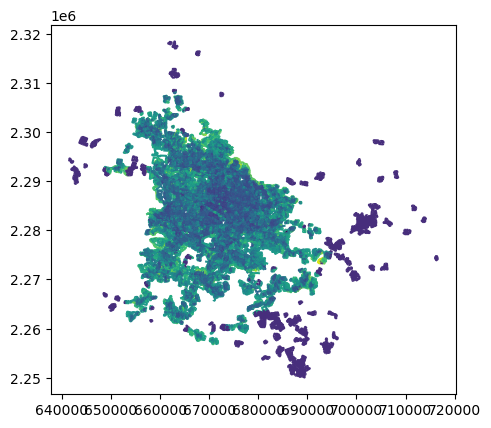

In [21]:
edges.plot("ndvi_mean")

In [59]:
edges.drop(columns="geometry").to_json("edges_ndvi.json", orient="records", lines=True)

In [60]:
edges.to_file("edges_with_ndvi.shp")

In [61]:
edges.to_file("edges_with_ndvi.geojson", driver="GeoJSON")

## Add __Land Use__ to analysis

In [11]:
print(predios['clasificacion_uso_suelo'].unique())

['ComercialServicios' 'Residencial' 'Mixto' 'Equipamiento'
 'Complementarios' 'Industrial']


In [8]:
edges_buffer = edges_var.copy()
edges_buffer['geometry'] = edges_buffer.buffer(30)

In [9]:
# Cargar datos
land_use = gpd.read_file("predios_uso_suelo.geojson")

# Convertir a coordenadas proyectadas para cálculos espaciales
land_use = land_use.to_crs('epsg:32613')
edges_buffer = edges_buffer.to_crs('epsg:32613')

# Filtrar solo los polígonos de uso de suelo Residencial
land_use_residencial = land_use[land_use['clasificacion_uso_suelo'].isin(['Residencial', 'Mixto'])]

# Calcular intersecciones solo con uso de suelo Residencial
intersections_residencial = gpd.overlay(edges_buffer, land_use_residencial, how='intersection')

# Mostrar las primeras filas
intersections_residencial.head()


,u,v,key,osmid,grade_abs,clasificacion_uso_suelo,geometry
0,9342184105,1793387649,0,167542247,0.000,Residencial,"POLYGON ((664124.696 2281984.683, 664123.807 2..."
1,1793387649,1660016550,0,127108560,0.013,Residencial,"POLYGON ((664138.500 2281987.153, 664119.820 2..."
2,1793387649,9342184105,0,167542247,0.000,Residencial,"POLYGON ((664124.696 2281984.683, 664123.807 2..."
3,1686407311,1394426259,0,127108581,0.010,Residencial,"POLYGON ((664131.897 2281991.295, 664134.410 2..."
4,1407606527,1793387649,0,127108560,0.017,Residencial,"POLYGON ((664124.617 2281984.388, 664123.699 2..."


In [10]:
if len(intersections_residencial) == 0:
    print("No hay intersecciones. Verifica las geometrías y los CRS.")
else:
    # Calcular el área de intersección
    intersections_residencial['area_inte'] = intersections_residencial.geometry.area

    # Sumar el área de intersección por cada segmento de calle
    area_usos_edges = intersections_residencial.groupby(['u', 'v', 'key'])['area_inte'].sum()

    # Calcular la proporción de cada uso de suelo
    land_use_presence_edges = intersections_residencial.groupby(['u', 'v', 'key', 'clasificacion_uso_suelo'])['area_inte'].sum()
    percentage_land_use_edges = land_use_presence_edges / area_usos_edges

    print("Número de intersecciones:", len(intersections_residencial))
    print("Número de calles únicas con intersecciones:", intersections_residencial[['u', 'v', 'key']].nunique())

    # Calcular el número de categorías por calle
    n_land_use = intersections_residencial.groupby(['u', 'v', 'key'])['clasificacion_uso_suelo'].unique().apply(len)

    # Aplicar la fórmula de entropía de Shannon
    def calcular_entropia(osmid, percentage_series):
        if osmid not in percentage_series.index or len(percentage_series.loc[osmid]) == 1:
            return 0  # Sin datos o solo un uso → entropía 0

        probs = percentage_series.loc[osmid].values
        return -np.sum(probs * np.log2(probs))

    edges_buffer['entropy'] = edges_buffer.set_index(['u', 'v', 'key']).index.map(
        lambda idx: calcular_entropia(idx, percentage_land_use_edges))

    # Convertir a CRS original y guardar resultado
    edges_buffer['buffer_wkt'] = edges_buffer['geometry'].apply(lambda geom: geom.wkt)   

Número de intersecciones: 3260232
Número de calles únicas con intersecciones: u      70478
v      70441
key        3
dtype: int64


In [16]:
print(edges_buffer['entropy'].unique())

[0.         0.23462849 0.69200725 ... 0.92144849 0.22871117 0.99166739]


In [12]:
edges_buffer

,u,v,key,osmid,grade_abs,geometry,entropy,buffer_wkt
0,1774344156,1827050267,0,782694623,0.014,"POLYGON ((675029.493 2274948.170, 675028.020 2...",0.0,"POLYGON ((675029.4927592592 2274948.170386933,..."
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"POLYGON ((674909.825 2275036.735, 674907.265 2...",0.0,POLYGON ((674909.8247008597 2275036.7351409537...
2,1774344156,4677618217,0,473698618,0.034,"POLYGON ((675100.162 2275027.270, 675102.779 2...",0.0,"POLYGON ((675100.162103643 2275027.270349188, ..."
3,1774344156,1827050277,0,782694623,0.012,"POLYGON ((675039.229 2275109.244, 675040.538 2...",0.0,"POLYGON ((675039.229048314 2275109.2439526436,..."
4,1827050267,1774344156,0,782694623,0.014,"POLYGON ((675008.086 2275037.765, 675009.558 2...",0.0,"POLYGON ((675008.0855375683 2275037.764706361,..."
...,...,...,...,...,...,...,...,...
414587,1390347431,1611189558,0,911043965,0.000,"POLYGON ((677653.994 2287498.065, 677656.819 2...",0.0,"POLYGON ((677653.993798156 2287498.0651871366,..."
414588,1390347431,4788435703,0,826248523,0.000,"POLYGON ((677644.838 2287385.891, 677644.046 2...",0.0,POLYGON ((677644.8384138402 2287385.8910745597...
414589,1611189448,1390347438,0,825936604,0.000,"POLYGON ((677572.637 2287224.490, 677569.759 2...",0.0,POLYGON ((677572.6373779246 2287224.4898589705...
414590,1611189448,1611189558,0,911043964,0.004,"POLYGON ((677589.666 2287349.039, 677617.689 2...",0.0,POLYGON ((677589.6663720611 2287349.0390375964...


## Sidewalks

In [8]:
gdf_tmp = hex_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.set_geometry("geometry")
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [9]:
query = f"SELECT * FROM censo_urbano.censo_fm_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
sidewalks = aup.gdf_from_query(query, geometry_col='geometry')
print(sidewalks.shape)
sidewalks.head(4)

(261012, 68)


,CVEGEO2,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,CVEVIAL_x,CVESEG,CVEFT_x,NOMVIAL_x,...,ESTACIONBICI,ARBOLES,ALUMPUB,TELPUB,PUESTOSEMI,PUESTOAMBU,BANQUETA,GUARNICION,TAMLOC,VIANOESP
0,1412000013185020,14,120,0001,3185,020,07967,00001,4,Ninguno,...,3,3,3,3,3,3,3,1,11,0
1,1412000013185020,14,120,0001,3185,020,07967,00001,6,Ninguno,...,3,3,1,3,3,3,3,1,11,0
2,1412000011850003,14,120,0001,1850,003,04876,00008,4,Trafalgar,...,3,1,1,3,3,3,1,1,11,0
3,1412000011850006,14,120,0001,1850,006,07991,00001,3,Pasamontes,...,3,1,3,3,3,3,1,1,11,0


In [10]:
edges_buffer = edges_var.copy()
edges_buffer['geometry'] = edges_buffer.buffer(30)

In [11]:
# Convertir a CRS proyectado (UTM)
sidewalks = sidewalks.to_crs('EPSG:32613')

In [12]:
print(sidewalks['BANQUETA'].unique())

[3 1 8 9]


In [46]:
sidewalks_banqueta = sidewalks[sidewalks['BANQUETA'].isin([1, 3, 8])]
sidewalks_banqueta.head(2)

,CVEGEO2,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,CVEVIAL_x,CVESEG,CVEFT_x,NOMVIAL_x,...,ESTACIONBICI,ARBOLES,ALUMPUB,TELPUB,PUESTOSEMI,PUESTOAMBU,BANQUETA,GUARNICION,TAMLOC,VIANOESP
0,1412000013185020,14,120,0001,3185,020,07967,00001,4,Ninguno,...,3,3,3,3,3,3,3,1,11,0
1,1412000013185020,14,120,0001,3185,020,07967,00001,6,Ninguno,...,3,3,1,3,3,3,3,1,11,0


In [47]:
print(sidewalks_banqueta['BANQUETA'].unique())

[3 1 8]


In [48]:
intersections = sidewalks_banqueta.overlay(edges_buffer, how='intersection')

In [50]:
if intersections.empty:
    print("No hay intersecciones. Saltando...")
    edges_buffer['sidewalk'] = 0  
else:
    # Asegurar que ambos GeoDataFrames tienen el mismo CRS
    edges_buffer = edges_buffer.to_crs('epsg:32613')
    sidewalks_banqueta3 = sidewalks_banqueta3.to_crs('epsg:32613')

    # Inicializar la columna 'sidewalk' con 0
edges_buffer['sidewalk'] = 0  

# Iterar sobre cada buffer en edges_buffer
for idx, edge in edges_buffer.iterrows():
    # Filtrar las banquetas contenidas en el buffer
    sidewalks_in_buffer = sidewalks_banqueta3[sidewalks_banqueta3['geometry'].within(edge['geometry'])]

    # Calcular la longitud total de banquetas dentro del buffer
    total_length = sidewalks_in_buffer['geometry'].length.sum()
    
    # Calcular la longitud de banquetas con BANQUETA = 1
    length_with_sidewalks = sidewalks_in_buffer[sidewalks_in_buffer['BANQUETA'] == 1]['geometry'].length.sum()
    
    # Evitar división por cero y calcular la proporción de banquetas
    if total_length > 0:
        edges_buffer.at[idx, 'sidewalk'] = length_with_sidewalks / total_length
    else:
        edges_buffer.at[idx, 'sidewalk'] = 0  # Si no hay banquetas en el buffer, asignar 0

# Convertir a CRS original y guardar resultados
edges_buffer = edges_buffer.to_crs('epsg:4326')
#edges_buffer.to_file('sidewalks_edges.geojson', driver='GeoJSON')

No hay intersecciones. Saltando...


In [51]:
edges_buffer.head(2)

,u,v,key,osmid,grade_abs,geometry,sidewalk,total_sidewalk_length,sidewalk_length
0,1774344156,1827050267,0,782694623,0.014,"POLYGON ((-103.32087 20.56537, -103.32094 20.5...",0,0.0,0.0
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"POLYGON ((-103.32201 20.56618, -103.32212 20.5...",0,0.0,0.0


In [52]:
print(edges_buffer['sidewalk'].unique())

[0]


## Densidad a edges

In [8]:
nodes_id = edges_var.v.unique().tolist()
u = edges_var.u.unique().tolist()
nodes_id.extend(u)
myset = set(nodes_id)
nodes_id = list(myset)
schema = 'censo'
nodes_folder = 'pobcenso_inegi_20_mzaageb_node'
nodes_query = f"SELECT * FROM {schema}.{nodes_folder} WHERE osmid IN {str(tuple(nodes_id))}"
nodes_pop = aup.gdf_from_query(nodes_query, geometry_col="geometry", index_col="osmid")

In [9]:
voronoi = gpd.read_file('/home/jovyan/accesibilidad-urbana/data/external/Guadalajara_script22_voronoipolys.gpkg')
voronoi = voronoi.to_crs("EPSG:32613")
voronoi['area_ha'] = voronoi.area/10000

In [10]:
# Realiza el merge para unir los datos de población y área desde `voronoi_gdf` a `nodes_gdf` basado en "osmid"
nodes_pop = nodes_pop.merge(
    voronoi[['osmid', 'area_ha']],  # Selecciona solo las columnas necesarias de voronoi_gdf
    on='osmid',
    how='left'
    )

# Verifica las primeras filas para asegurarte de que el merge se realizó correctamente
nodes_pop.head(3)

,osmid,geometry,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3a5,p_3a5_f,...,p_18ymas,p_18ymas_f,p_18ymas_m,pob0_14,pob15_64,pob65_mas,pcon_disc,dens_pob_ha,city,area_ha
0,28751344,POINT (-103.30631 20.71153),74.890169,39.475573,35.414596,4.052830,2.794774,1.258056,3.547978,2.176828,...,55.442126,28.343083,27.099043,16.518011,52.241580,6.130578,2.055585,155.402389,Guadalajara,0.486014
1,28753224,POINT (-103.31665 20.70065),180.215453,94.978818,85.236635,4.968364,3.053272,1.915092,6.664361,2.904487,...,134.938995,71.333002,63.605993,35.514429,119.215103,25.485921,5.448743,245.808088,Guadalajara,0.739377
2,28757751,POINT (-103.30736 20.70853),58.046111,30.809445,27.236666,2.264263,1.294463,0.969800,2.744622,1.903764,...,40.472681,20.763925,19.708756,14.490449,37.168716,6.386946,2.730570,57.898034,Guadalajara,1.011087


In [11]:
nodes_pop['dens'] = nodes_pop['pobtot'] / nodes_pop['area_ha']
nodes_pop.head(3)

,osmid,geometry,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3a5,p_3a5_f,...,p_18ymas_f,p_18ymas_m,pob0_14,pob15_64,pob65_mas,pcon_disc,dens_pob_ha,city,area_ha,dens
0,28751344,POINT (-103.30631 20.71153),74.890169,39.475573,35.414596,4.052830,2.794774,1.258056,3.547978,2.176828,...,28.343083,27.099043,16.518011,52.241580,6.130578,2.055585,155.402389,Guadalajara,0.486014,154.090606
1,28753224,POINT (-103.31665 20.70065),180.215453,94.978818,85.236635,4.968364,3.053272,1.915092,6.664361,2.904487,...,71.333002,63.605993,35.514429,119.215103,25.485921,5.448743,245.808088,Guadalajara,0.739377,243.739639
2,28757751,POINT (-103.30736 20.70853),58.046111,30.809445,27.236666,2.264263,1.294463,0.969800,2.744622,1.903764,...,20.763925,19.708756,14.490449,37.168716,6.386946,2.730570,57.898034,Guadalajara,1.011087,57.409613


In [12]:
edges_var = edges_var.merge(nodes_pop[['osmid','dens']],
                           left_on='u', right_on='osmid',
                           how='left')
edges_var = edges_var.rename(columns={'dens':'dens_u'})
edges_var.head(2)

,u,v,key,osmid_x,grade_abs,geometry,osmid_y,dens_u
0,1774344156,1827050267,0,782694623,0.014,"LINESTRING (675034.767 2275024.049, 675002.812...",1.774344e+09,67.525184
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"LINESTRING (675034.767 2275024.049, 674919.897...",1.774344e+09,67.525184


In [20]:
edges_var = edges_var.merge(nodes_pop[['osmid','dens']],
                           left_on='v', right_on='osmid',
                           how='left')
edges_var = edges_var.rename(columns={'dens':'dens_v'})
edges_var.head(2)

,u,v,key,osmid_x,grade_abs,geometry,osmid_y,dens_u,osmid,dens_v
0,1774344156,1827050267,0,782694623,0.014,"LINESTRING (675034.767 2275024.049, 675002.812...",1.774344e+09,67.525184,1.827050e+09,80.805215
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"LINESTRING (675034.767 2275024.049, 674919.897...",1.774344e+09,67.525184,6.511606e+09,54.953020


In [26]:
# Combinar para obtener los datos del nodo de origen 'u'
edges_with_u = edges_var.merge(
    nodes_pop[['osmid', 'pobtot', 'area_ha', "geometry"]], 
    left_on='u',  # Unir usando la columna 'u' de edges
    right_on='osmid',  # Une con la columna 'osmid' de nodes_gdf
    how='left',
    suffixes = ("_edge", "_node")
).rename(columns={'pobtot': 'pobtot_u', 'area_ha': 'area_ha_u'})  # Renombra columnas para evitar conflictos

In [27]:
# Combinar para obtener los datos del nodo de destino 'v'
edges_with_uv = edges_with_u.merge(
    nodes_pop[['osmid', 'pobtot', 'area_ha', "geometry"]], 
    left_on='v', # Unir usando la columna 'v' de edges
    right_on='osmid',  # Unir con la columna 'osmid' de nodes_gdf
    how='left',  # Mantiene todas las filas de edges_with_u
    suffixes = ("_edge", "_node")
).rename(columns={'pobtot': 'pobtot_v', 'area_ha': 'area_ha_v'})  # Renombra columnas para evitar conflictos

In [28]:
edges_with_uv.columns

Index(['u', 'v', 'key', 'osmid_x', 'grade_abs', 'geometry_edge', 'osmid_y',
       'dens_u', 'osmid_edge', 'dens_v', 'osmid_node', 'pobtot_u', 'area_ha_u',
       'geometry_node', 'osmid', 'pobtot_v', 'area_ha_v', 'geometry'],
      dtype='object')

In [30]:
# Calcular la densidad de cada nodo
edges_with_uv['dens_u'] = edges_with_uv['pobtot_u'] / edges_with_uv['area_ha_u']
edges_with_uv['dens_v'] = edges_with_uv['pobtot_v'] / edges_with_uv['area_ha_v']
edges_with_uv["average_population"] = (edges_with_uv['pobtot_u'] + edges_with_uv['pobtot_v']) / 2
edges_with_uv["total_pobtot"] = edges_with_uv['pobtot_u'] + edges_with_uv['pobtot_v']

# Calcular la densidad promedio para cada arista (promedio de los nodos u y v)
edges_with_uv['average_density'] = (edges_with_uv['dens_u'] + edges_with_uv['dens_v']) / 2

In [31]:
edges_with_uv.head(2)

,u,v,key,osmid_x,grade_abs,geometry_edge,osmid_y,dens_u,osmid_edge,dens_v,...,pobtot_u,area_ha_u,geometry_node,osmid,pobtot_v,area_ha_v,geometry,average_population,total_pobtot,average_density
0,1774344156,1827050267,0,782694623,0.014,"LINESTRING (675034.767 2275024.049, 675002.812...",1.774344e+09,67.525184,1.827050e+09,80.805215,...,46.632436,0.690593,POINT (-103.32081 20.56605),1.827050e+09,58.237898,0.720720,POINT (-103.32112 20.56550),52.435167,104.870334,74.165200
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"LINESTRING (675034.767 2275024.049, 674919.897...",1.774344e+09,67.525184,6.511606e+09,54.953020,...,46.632436,0.690593,POINT (-103.32081 20.56605),6.511606e+09,29.609449,0.538814,POINT (-103.32160 20.56705),38.120943,76.241885,61.239102


In [34]:
edges_with_uv = edges_with_uv[['osmid', 'u', 'v', "key", 'dens_u', 'dens_v', 'average_density', "average_population", "total_pobtot", 
                               "geometry_edge", "grade_abs"]]
edges_with_uv.rename(columns = {"geometry_edge" : "geometry"}, inplace = True)
edges_with_uv.head()

,osmid,u,v,key,dens_u,dens_v,average_density,average_population,total_pobtot,geometry,grade_abs
0,1.827050e+09,1774344156,1827050267,0,67.525184,80.805215,74.165200,52.435167,104.870334,"LINESTRING (675034.767 2275024.049, 675002.812...",0.014
1,6.511606e+09,1774344156,6511605645,0,67.525184,54.953020,61.239102,38.120943,76.241885,"LINESTRING (675034.767 2275024.049, 674919.897...",0.005
2,4.677618e+09,1774344156,4677618217,0,67.525184,148.872395,108.198790,57.917122,115.834244,"LINESTRING (675034.767 2275024.049, 675087.745...",0.034
3,1.827050e+09,1774344156,1827050277,0,67.525184,51.738733,59.631959,27.279865,54.559731,"LINESTRING (675034.767 2275024.049, 675066.723...",0.012
4,1.774344e+09,1827050267,1774344156,0,80.805215,67.525184,74.165200,52.435167,104.870334,"LINESTRING (675002.812 2274961.886, 675034.767...",0.014


In [35]:
if 'geometry' in edges_with_uv.columns:
    edges_with_uv = gpd.GeoDataFrame(edges_with_uv, geometry='geometry') 

    edges_with_uv.to_file("Poblational_density.geojson", driver="GeoJSON")
else:
    print("Error: El DataFrame no tiene una columna 'geometry'.")